In [1]:
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from readcount_tools import broken_zeta, add_largedot_legend
#import plotting constants
from readcount_tools import PAPER_CONTEXT, PAGEWIDTH_IN, POINTSIZE_HIGHLIGHT,POINTSIZE_SMALL,SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE,LINEWIDTH,POINTSIZE,TICKLENGTH,LEGEND_FONTSIZE,SPINEWIDTH,LETTER_LOC_X,LETTER_LOC_Y

### Load preproc results

In [2]:
basepath = 'data/reads_per_umi_tables/'

In [3]:
%%time
#1min30sec
with open(f'{basepath}reads_per_umi_dfs_hd1_preproc.pickle','rb') as f:
    dfs = pickle.load(f) 

tcmalloc: large alloc 1073741824 bytes == 0x76e60000 @ 
tcmalloc: large alloc 2147483648 bytes == 0xf1712000 @ 
tcmalloc: large alloc 4294967296 bytes == 0x1f79b0000 @ 


CPU times: user 46.3 s, sys: 29.2 s, total: 1min 15s
Wall time: 1min 15s


### Prepare Fig3

In [4]:
exps = [df.index[0] for df in dfs]
protocols = [e.replace('_Fibroblast_PE','P').replace('_Fibroblast','S') for e in exps]
runs = [p[-1] for p in protocols]
runs = [r.replace('P','PE') for r in runs]
runs = [r.replace('S','SE') for r in runs]
protocols = [p[:-1] for p in protocols]
colormap = {'CELseq2':'tab:blue', 
            'DropSeq':'tab:orange', 
            'MARSseq':'tab:green', 
            'SCRBseq':'tab:red', 
            'Smartseq3':'tab:brown',
            '':'tab:olive',}
prot2print = dict(CELseq2='CEL-seq2',
                    DropSeq='Drop-seq',
                    MARSseq='MARS-seq',
                    SCRBseq='SCRB-seq',
                    Smartseq3='Smart-seq3')

### Figure 3: Paper version

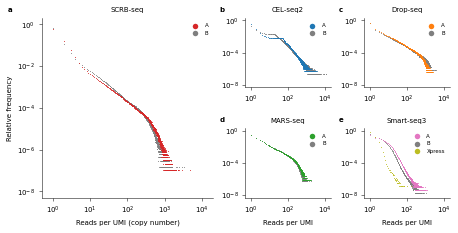

In [5]:
ncols = 2
figheight_in = PAGEWIDTH_IN/ncols

path='figures/main_observed_amplification.pdf'
with mpl.rc_context(PAPER_CONTEXT):
    
    fig = plt.figure(figsize=(PAGEWIDTH_IN,figheight_in), constrained_layout=True)
    spec = fig.add_gridspec(2, 4)

    ax_big = fig.add_subplot(spec[:2, :2])
    ax00 = fig.add_subplot(spec[0, 2])
    ax01 = fig.add_subplot(spec[0, 3])
    ax10 = fig.add_subplot(spec[1, 2])
    ax11 = fig.add_subplot(spec[1, 3])

    axmap = {'CELseq2':ax00, 'DropSeq':ax01, 'MARSseq':ax10, 'SCRBseq':ax_big, 'Smartseq3':ax11}

    for df,exp,protocol,run in zip(dfs,exps,protocols,runs):  
        
        if protocol=='Smartseq3xpress':
            protocol = 'Smartseq3'
            run = 'Xpress'
            color = 'tab:olive'
            zorder=4
        elif run=='SE':
            color = 'tab:pink'
            zorder=4
        elif run=='A':
            color = colormap[protocol]
            zorder=4
        else:
            color = 'tab:gray'
            zorder=3
            
        ax = axmap[protocol]
        if run == 'SE':
            runlabel = 'A'
        elif run == 'PE':
            runlabel = 'B'
        else:
            runlabel = run
        
        reads_per_umi,abs_frequency = np.unique(df['N'],return_counts=True)
        rel_frequency = abs_frequency/sum(abs_frequency)
        ax.scatter(reads_per_umi,rel_frequency,
                   label=runlabel,c=color,
                   linewidth=0,s=POINTSIZE,rasterized=True,zorder=zorder)

        ax.set_yscale('log')
        ax.set_xscale('log')
        if protocol == 'SCRBseq':
            ax.set_ylabel('Relative frequency')
            ax.set_xlabel('Reads per UMI (copy number)')
            plt.sca(ax)
            plt.xticks([10**0, 10**1, 10**2, 10**3, 10**4])
            plt.yticks([10**-8,10**-6,10**-4,10**-2,10**0]) 
        elif protocol in ['MARSseq','Smartseq3']:
            ax.set_xlabel('Reads per UMI')
            plt.sca(ax)
            plt.xticks([10**0,10**2,10**4])
            plt.yticks([10**-8,10**-4,10**0])
        else:
            plt.sca(ax)
            plt.xticks([10**0,10**2,10**4])
            plt.yticks([10**-8,10**-4,10**0])

        ax.minorticks_off()
        

        add_largedot_legend(ax,loc='upper right',kwargs=dict(fontsize=LEGEND_FONTSIZE,frameon=False))
        ax.set_title(prot2print[protocol])
        
        ax.set_ylim(10**-8.3,10**0.3)
        ax.set_xlim(10**-0.3,10**4.3)
        
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(SPINEWIDTH)
    
    sns.despine()   
        

   
    letters=['a','b','c','d','e']
    x_corrections=[0.1,0,0,0,0]
    y_corrections=[0.085,0.14,0.14,0.14,0.14]
        
    for ax,letter,x_corr,y_corr in zip([ax_big,ax00,ax01,ax10,ax11],letters,x_corrections,y_corrections):
        ax.text(LETTER_LOC_X+x_corr,LETTER_LOC_Y+y_corr,letter,transform=ax.transAxes,fontweight='bold')
    
    plt.savefig(path, dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

### Table 1

In [6]:
def get_observed_stats(dfs,quick=True):
    if quick:
        print('           \tmax\tmean\tff\tnum\talpha',end='\n')
    else:
        print('           \tn\tmax\tmean\tff\tnum\talpha',end='\n')
    stat_rows = []
    for df in dfs:
        
        row = dict()
        
        exp_name = df.index.values[0]
        if 'Smartseq3' in exp_name:
            exp_name = exp_name.replace('Smartseq3_Fibroblast','Smrtsq3')
            exp_name = exp_name.replace('Smartseq3xpress','Smrtsq3xpr')
    
        print(exp_name,end=':\t')
        if not quick:
            n_cells = len(np.unique(df['RG']))
            print(n_cells,end='\t',sep='')

        data = df['N'].values
        max_=np.max(data)
        print(int(max_),end='\t',sep='')
        mean=np.mean(data)
        var=np.var(data)
        print(np.round(mean,decimals=1),end='\t',sep='')
        print(np.round(var/mean,decimals=1),end='\t',sep='')
        print(len(data),end='\t',sep='')
        print(np.round(mean + (var/mean),decimals=1),end='\t',sep='')
        print('',end='\n')
        
        row['exp'] = exp_name
        row['mean'] = mean
        row['ff']=var/mean
        row['max']=max_
        row['alpha']=row['mean']+row['ff']
        row['n_UMIs']=len(data)
        row['n_cells']=n_cells
        stat_rows.append(row)
    return pd.DataFrame(stat_rows)

In [7]:
%%time
observed_amp_stats_df = get_observed_stats(dfs,quick=False)
observed_amp_stats_df.set_index('exp',inplace=True)

           	n	max	mean	ff	num	alpha
CELseq2A:	34	3476	27.2	107.5	2140365	134.8	
CELseq2B:	37	11092	24.4	199.8	4303956	224.2	
DropSeqA:	42	2463	29.6	284.2	2506244	313.8	
DropSeqB:	34	3718	31.1	414.1	1272895	445.2	
MARSseqA:	29	1624	24.1	132.1	1342232	156.2	
MARSseqB:	36	1719	20.9	107.0	1903673	128.0	
SCRBseqA:	39	4840	9.7	218.8	9429371	228.5	
SCRBseqB:	45	3276	9.4	159.3	6800371	168.7	
Smrtsq3:	145	1216	5.4	8.0	21549849	13.4	
Smrtsq3_PE:	319	989	3.8	4.5	48073893	8.3	
Smrtsq3xprA:	96	173	1.3	0.3	6940889	1.6	
CPU times: user 2min 53s, sys: 8.29 s, total: 3min 1s
Wall time: 2min 58s


In [8]:
observed_amp_stats_df.n_cells.sum()

856

In [9]:
observed_amp_stats_df.n_UMIs.sum()

106263738

### Prepare Figure 4

In [10]:
exp_fig4_name = 'DropSeqA'
protocol_fig4='DropSeq'
exp_fig4_id = np.where([np.array(exps)==exp_fig4_name])[1][0]

In [11]:
obsdata = dfs[exp_fig4_id]['N']

a1_sim= 1.4
a2_sim= 4.5
b_sim=500

a1_grid= np.linspace(1.0,5.0, num=20)
a2_grid= np.linspace(3.0, 10.0, num=20)
breakpoint_grid= [b_sim]

n_sim = len(obsdata)
simdata,p = broken_zeta(a1=a1_sim,
                      a2=a2_sim,
                      breakpoint=b_sim,
                      size=n_sim,return_p=True)

print(f'\t\tE_Z \t\t\tFF_Z')
print('observed',np.mean(obsdata),np.var(obsdata)/np.mean(obsdata),sep='\t')
print('simulated',np.mean(simdata),np.var(simdata)/np.mean(simdata),sep='\t')

		E_Z 			FF_Z
observed	29.633605107882552	284.17879402825855
simulated	29.07421144948377	284.12615547072755


In [12]:
%%time
means = np.zeros((len(a1_grid),len(a2_grid),len(breakpoint_grid)))
maxs = np.zeros((len(a1_grid),len(a2_grid),len(breakpoint_grid)))
FFs = np.zeros((len(a1_grid),len(a2_grid),len(breakpoint_grid)))
alphas = np.zeros((len(a1_grid),len(a2_grid),len(breakpoint_grid)))

for i_a1,a1 in enumerate(a1_grid):
    for i_a2,a2 in enumerate(a2_grid):
        for i_breakpoint,breakpoint in enumerate(breakpoint_grid):
            
            x = broken_zeta(a1=a1,
                      a2=a2,
                      breakpoint=breakpoint,
                      size=n_sim,z_max=1000000)
            
            means[i_a1,i_a2,i_breakpoint] = np.mean(x)
            var  = np.var(x)
            maxs[i_a1,i_a2,i_breakpoint] = np.max(x)            
            FFs[i_a1,i_a2,i_breakpoint] = var / means[i_a1,i_a2,i_breakpoint]
            alphas[i_a1,i_a2,i_breakpoint] = means[i_a1,i_a2,i_breakpoint] + FFs[i_a1,i_a2,i_breakpoint]

CPU times: user 56.4 s, sys: 668 ms, total: 57.1 s
Wall time: 57.1 s


In [13]:
np.max(maxs)

164318.0

### Figure 4

In [14]:
def plot_inset(ax):

    ax.plot([10**0, 10**2],[10**0,10**-4],lw=LINEWIDTH,c='tab:red')
    ax.text(10**1,10**-5.5,r'slope $a_1$',ha='center',rotation=334,c='tab:red',fontweight='bold',fontsize=LEGEND_FONTSIZE)

    ax.plot([10**2, 10**3],[10**-4,10**-12],lw=LINEWIDTH,c='tab:green')
    ax.text(10**2.8,10**-10.5,r'slope $a_2$',ha='center',rotation=298,c='tab:green',fontweight='bold',fontsize=LEGEND_FONTSIZE)

    ax.vlines(10**2,10**-12,10**-1.2,linestyles=':',colors='tab:gray',lw=LINEWIDTH)
    ax.text(10**2.2,10**-0.8,r'breakpoint $b$',ha='center',c='tab:gray',fontweight='bold',fontsize=LEGEND_FONTSIZE)

    ax.set_ylabel(r'$p(z)$') 
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlabel('z')
    
    ax.set_xticks([])
    ax.set_yticks([])
    

    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(SPINEWIDTH)

    sns.despine(ax=ax)

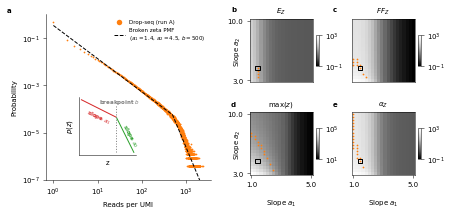

In [15]:
ncols = 4
figheight_in = PAGEWIDTH_IN/ncols * 2
path='figures/main_dropseq_broken_zeta.pdf'
with mpl.rc_context(PAPER_CONTEXT):
    
    fig = plt.figure(figsize=(PAGEWIDTH_IN,figheight_in))
    spec = fig.add_gridspec(2, 4)

    ax_big = fig.add_subplot(spec[:2, :2])
    ax10 = fig.add_subplot(spec[1, 2])
    ax11 = fig.add_subplot(spec[1, 3],sharey=ax10)
    ax00 = fig.add_subplot(spec[0, 2],sharex=ax10)
    ax01 = fig.add_subplot(spec[0, 3],sharey=ax00,sharex=ax11)
    
    ax_inset = ax_big.inset_axes([0.2,0.15,0.35,0.35])    

    
    reads_per_umi,abs_frequency = np.unique(obsdata,return_counts=True)
    rel_frequency = abs_frequency/sum(abs_frequency)
    ax_big.scatter(reads_per_umi,rel_frequency,
                   label='Drop-seq (run A)',c=colormap[protocol_fig4],
                   linewidth=0,s=POINTSIZE_HIGHLIGHT,rasterized=True)
    ax_big.set_yscale('log')
    ax_big.set_xscale('log')
    ax_big.set_ylabel('Probability')
    ax_big.set_xlabel('Reads per UMI')
    ax_big.minorticks_off()
    ax_big.set_ylim([10**-7,1])
    sns.despine(ax=ax_big)

    obs_max = np.max(obsdata)
    x=np.arange(len(p))+1
    pmf_label='Broken zeta PMF\n' fr'($a_1={a1_sim}$, $a_2={a2_sim}$, $b={b_sim}$)'
    ax_big.plot(x[:obs_max],p[:obs_max],'--',color='k',linewidth=LINEWIDTH,label=pmf_label)
    add_largedot_legend(ax_big,loc='best',kwargs=dict(fontsize=LEGEND_FONTSIZE,frameon=False))
    plot_inset(ax_inset)

    
    
    ### HEATMAPS ###
    all_data = np.array([means,FFs,maxs,alphas])
    shared_map_data = np.array([means,FFs,alphas])
    logmin_shared = np.log10(np.min(shared_map_data))
    logmax_shared = np.log10(np.max(shared_map_data))
    
    for i,(ax,data,stat,title) in enumerate(zip([ax00,ax01,ax10,ax11],
                                           [means,FFs,maxs,alphas],
                                           ['mean','ff','max','alpha'],
                                           [r'$E_Z$','$FF_Z$',r'$\max(z)$',r'$\alpha_Z$'])):
        
        data=data[:,:,0].T ##transpose to make a1 (first dimension in array) the x-axis dimension
        tolerance_level=0.1
        obs_stat_lo_tol = observed_amp_stats_df.loc['DropSeqA',stat] * (1-tolerance_level)
        obs_stat_hi_tol = observed_amp_stats_df.loc['DropSeqA',stat] * (1+tolerance_level)
        
        sim_matching_obs_idx = (data >= obs_stat_lo_tol) & (data <= obs_stat_hi_tol)
        y_match,x_match = np.where(sim_matching_obs_idx)
        
        sim_a1_idx = np.argmin(np.abs(a1_grid - a1_sim))
        sim_a2_idx = np.argmin(np.abs(a2_grid - a2_sim))
        
        
        if i in [2,3]:
            ax.set_xlabel(r'Slope $a_1$',labelpad=10.25)
            ax.set_xticks(ticks=np.arange(len(a1_grid))[::len(a1_grid)-1])
            ax.set_xticklabels(labels=a1_grid[::len(a1_grid)-1])

        if i in [0,2]:
            ax.set_ylabel(r'Slope $a_2$',labelpad=-15)
            ax.set_yticks(ticks=np.arange(len(a2_grid))[::len(a2_grid)-1])
            ax.set_yticklabels(labels=np.round(a2_grid[::len(a2_grid)-1],decimals=1))
            
        ax.set_title(title)
        if stat in ['mean','ff','alpha']:
            im = ax.imshow(np.log10(data),origin='lower',cmap='Greys_r',vmin=logmin_shared,vmax=logmax_shared)
            ticks=[logmin_shared,logmax_shared]
        else:
            im = ax.imshow(np.log10(data),origin='lower',cmap='Greys_r')
            ticks=[np.log10(np.min(data)),np.log10(np.max(data))]
        ax.scatter(x_match,y_match,s=POINTSIZE_HIGHLIGHT,c='tab:orange',linewidth=0)
        ax.scatter(sim_a1_idx,sim_a2_idx,marker='s',facecolor='none',edgecolor='k',linewidth=LINEWIDTH,s=20)
        
        cax = ax.inset_axes([1.05,0.25,0.05,0.5])
        cbar = plt.colorbar(im,cax=cax,ticks=ticks)
        cbar_y =cbar.ax.get_yaxis()
        cbar_ticklocs = cbar_y.get_ticklocs()
        cbar_y.set_ticks(cbar_ticklocs)
        cbar_y.set_ticklabels([fr'$10^{{{np.round(v,decimals=0).astype(int)}}}$' for v in cbar_ticklocs])
        cbar.outline.set_linewidth(SPINEWIDTH)
    
    #hide y ticklabels in 2nd clm
    plt.setp(ax01.get_yticklabels(), visible=False)
    ax01.tick_params(axis='y',length=0)
    plt.setp(ax11.get_yticklabels(), visible=False)
    ax11.tick_params(axis='y',length=0)
    
    #hide x ticklabels in 1st row
    plt.setp(ax00.get_xticklabels(), visible=False)
    ax00.tick_params(axis='x',length=0)
    plt.setp(ax01.get_xticklabels(), visible=False)
    ax01.tick_params(axis='x',length=0)        
    
    plt.tight_layout()
    
    #panel letters
    letters=['a','b','c','d','e']
    x_corrections=[0.065,0,0,0,0]
    y_corrections=[0.065,0.175,0.175,0.14,0.14]
        
    for i,(ax,letter,x_corr,y_corr) in enumerate(zip([ax_big,ax00,ax01,ax10,ax11,cax],letters,x_corrections,y_corrections)):
        ax.text(LETTER_LOC_X+x_corr,LETTER_LOC_Y+y_corr,letter,transform=ax.transAxes,fontweight='bold')
        if i == 0:
            axes = ['bottom','left'],
        else:
            axes = ['bottom','left', 'top', 'right']
        for axis in axes:
            ax.spines[axis].set_linewidth(SPINEWIDTH)
    
    
    fig.savefig(path, dpi=1000, format=None, bbox_inches = 'tight', pad_inches = 0)